In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import glob
import readchar
import time
from numba import jit, njit

In [3]:
def get_coeff(t):

    x1 = 1.2165
    y1 = 0.5
    x2 = 1.2701
    y2 = 0.1
    slope = (y1-y2)/(x1-x2)
    coeff = y1 + slope * (t - x1)

    return coeff



#===== getPE
@njit
def getPE(pos, m, G, epsilon):

    N = pos.shape[0]

    dx = np.empty(3)
    PE = 0.0

    for i in range(N):
        for j in range(i+1, N):

            dx = pos[i, 0] - pos[j, 0]
            dy = pos[i, 1] - pos[j, 1]
            dz = pos[i, 2] - pos[j, 2]

            rr = (dx**2 + dy**2 + dz**2)**0.5				

            fk = 0.0

            if rr != 0.0 :
                inv_r = 1.0 / rr

            epsilonij = 0.5 * (epsilon[i] + epsilon[j])
            q = rr / epsilonij

            if (q <= 1.0) & (q != 0.0):
                fk = m[j] * ((-2.0/epsilonij) * ( (1.0/3.0)*q**2 - (3.0/20.0)*q**4 + (1.0/20.0)*q**5 ) + 7.0/5.0/epsilonij)

            if (q > 1.) and (q <= 2.):
                fk = m[j]*((-1.0/15.0)*inv_r - (1.0/epsilonij) * ((4.0/3.0)*q**2 - q**3 + (3.0/10.0)*q**4 - (1.0/30.0)*q**5) + 8.0/5.0/epsilonij)

            if q > 2.:
                fk = m[j] * inv_r

            PE -= G * m[i] * fk

    return PE

UnitDensity_in_cgs = 1.64066540313862e-17 g/cm^3
Total particles to process =  3518
j =  600
(1329,) 0.42985074626865627
[0.43753067]
j =  610
(1224,) 0.3970149253731342
[0.42959487]
j =  620
(1137,) 0.3656716417910449
[0.42871189]
j =  630
(1061,) 0.3365671641791045
[0.43434304]
j =  640
(998,) 0.30970149253731316
[0.42476593]
j =  650
(903,) 0.28432835820895447
[0.41936503]
j =  660
(827,) 0.26119402985074647
[0.41728104]
j =  670
(760,) 0.24029850746268577
[0.41240247]
j =  680
(707,) 0.22089552238805943
[0.40130814]
j =  690
(661,) 0.20373134328358206
[0.38898577]
j =  700
(633,) 0.18805970149253737
[0.38161699]
j =  710
(593,) 0.1746268656716417
[0.36414062]
j =  720
(549,) 0.16194029850746233
[0.34978091]
j =  730
(504,) 0.15149253731343204
[0.34231806]
j =  740
(452,) 0.14179104477611965
[0.31295987]
j =  750
(422,) 0.13358208955223833
[0.29269104]
j =  760
(391,) 0.1268656716417913
[0.26836855]
j =  770
(376,) 0.120895522388059
[0.24652242]
j =  780
(350,) 0.11567164179104467
[

/tmp/ipykernel_67792/3445903297.py:115: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res)


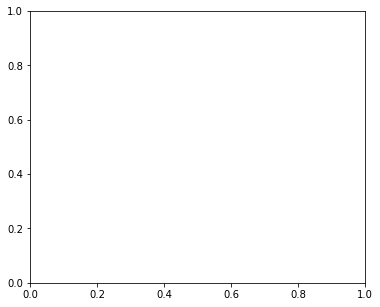

In [8]:
TA = time.time()

M_sun = 1.98992e+33 # gram
UnitMass_in_g = 1.0 * M_sun       # !!!!!!!!!!!!!!!!!!!!!!!!! CHANGE !!!!!!!!!!!!!!!!!
UnitRadius_in_cm = 4.95e+16  #!!!!!!!!!!!!!! CHANGE !!!!!!!!!!!!!!!!!!
UnitDensity_in_cgs = UnitMass_in_g / UnitRadius_in_cm**3

G = 6.67259e-8 #  cm3 g-1 s-2

print(f'UnitDensity_in_cgs = {UnitDensity_in_cgs} g/cm^3')



filz = np.sort(glob.glob('./Outputs/*.pkl'))

filz = np.sort(glob.glob('/mnt/Linux_Shared_Folder_2022/Outputs_60k_UA/*.pkl'))


plt.ion()
fig, ax = plt.subplots(figsize = (6, 5))

kb = ''

res = []

print('Total particles to process = ', len(filz))

for j in range(600, len(filz), 10):  # 35.54 + 1 = 36.54

    print('j = ', j)

    with open(filz[j], 'rb') as f:
        data = pickle.load(f)

    r = data['pos']
    h = data['h']
    m = data['m']
    v = data['v']

    x = r[:, 0]
    y = r[:, 1]
    z = r[:, 2]
    t = data['current_t']
    rho = data['rho']
    unitTime_in_kyr = data['unitTime'] /3600./24./365.25/1000.
    t_ff = data['t_ff']
    unitVelocity = data['unitVelocity']

    t_t_ff = round(t*data['unitTime']/t_ff, 4) # t/t_ff

    rho = rho*UnitDensity_in_cgs

    nyneg = np.where(y < 0.0)[0]

    xneg = x[nyneg]
    yneg = y[nyneg]
    zneg = z[nyneg]

    rhoneg = rho[nyneg]
    mneg = m[nyneg]
    hneg = h[nyneg]
    vneg = v[nyneg]

    #-- This is only for plotting purpose
    n_rho_max_1 = np.where(rhoneg == max(rhoneg))[0]
    xmax1 = xneg[n_rho_max_1]
    ymax1 = yneg[n_rho_max_1]
    zmax1 = zneg[n_rho_max_1]
    #----------

    #--- coord. of the fragment particles
    nfrag1 = np.where(rhoneg >= get_coeff(t_t_ff)*max(rhoneg))[0]
    
    print(nfrag1.shape, get_coeff(t_t_ff))
    
    xfrag1 = xneg[nfrag1].reshape((-1, 1))
    yfrag1 = yneg[nfrag1].reshape((-1, 1))
    zfrag1 = zneg[nfrag1].reshape((-1, 1))

    mfrag1 = mneg[nfrag1]
    rhofrag1 = rhoneg[nfrag1]
    hfrag1 = hneg[nfrag1]

    vfrag1 = vneg[nfrag1]

    vxfrag1 = vfrag1[:, 0]
    vyfrag1 = vfrag1[:, 1]
    vzfrag1 = vfrag1[:, 2]

    epsilonfrag1 = hfrag1.copy()

    #--- Calculation the grav. PE -----
    rfrag1 = np.hstack((xfrag1, yfrag1, zfrag1))

    PE = getPE(rfrag1*UnitRadius_in_cm, mfrag1*UnitMass_in_g, G, epsilonfrag1*UnitRadius_in_cm)

    
    
    #--- Calculating rotational Energy -----

    Erot = 0.0
    for i in range(len(xfrag1)):

        rtmp = (xfrag1[i]**2 + yfrag1[i]**2)**0.5

        vphi = (xfrag1[i]*vyfrag1[i] - yfrag1[i]*vxfrag1[i]) / rtmp

        Erot += 0.5 * mfrag1[i]*UnitMass_in_g * (vphi*unitVelocity)**2

    res.append([t_t_ff, np.abs(Erot/PE)])
    
    print(np.abs(Erot/PE))
    
    if get_coeff(t_t_ff) < 0.09:
        break

res = np.array(res)

t = res[:, 0]
Beta = res[:, 1]
    
print('Elapsed time = ', time.time() - TA)

(0.0, 5.0)

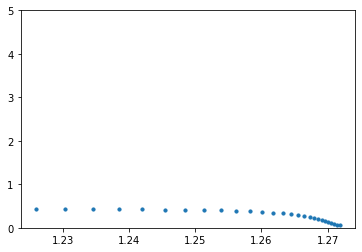

In [6]:
plt.scatter(t, Beta, s = 10)
plt.ylim(0, 5)